In [2]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter('ignore')

#### pystan windows C++ compiler

* conda install libpython m2w64-toolchain -c msys2 --yes 

In [3]:
import os
import platform

dependencies_installed = True
if platform.system() == 'Windows' and not dependencies_installed:
    os.system("conda install libpython m2w64-toolchain -c msys2 --yes")

In [4]:
### pystan leveraged by fbprophet need to test before using kats
import pystan

if not dependencies_installed:
    model_code = 'parameters {real y;} model {y ~ normal(0,1);}'
    model = pystan.StanModel(model_code=model_code)  # this will take a minute
    y = model.sampling(n_jobs=1).extract()['y']
    print(y.mean())  # should be close to 0

In [5]:
import pandas as pd
import numpy as np
from kats.consts import TimeSeriesData

def retrieve_example_url(csv_name):
    url_path = f'https://raw.githubusercontent.com/facebookresearch/Kats/master/kats/data/{csv_name}.csv'
    return url_path
air_passengers_df = pd.read_csv(retrieve_example_url(csv_name='air_passengers'))
air_passengers_df.columns = ['time','value']
air_passengers_ts = TimeSeriesData(air_passengers_df)

#### Ensemble Air Passengers Univariate Example

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:root:Generated forecast data from arima model.
INFO:root:Generated forecast data from SARIMA model.
INFO:root:Generated forecast data from Prophet model.
INFO:root:Generated forecast data from theta model.
INFO:root:Generated forecast data from Prophet model.
INFO:root:Generated forecast data from theta model.
INFO:root:Generating chart for forecast result from Ensemble model.
INFO:root:Generating chart for forecast result.


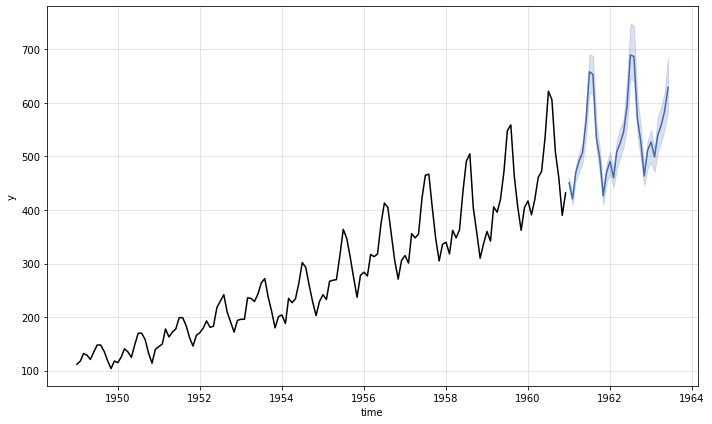

In [6]:
from kats.models.ensemble.ensemble import EnsembleParams, BaseModelParams
from kats.models.ensemble.kats_ensemble import KatsEnsemble
from kats.models import (arima, holtwinters, linear_model, prophet, quadratic_model, sarima, theta)

model_params = EnsembleParams(
    [
        BaseModelParams('arima',arima.ARIMAParams(p=1,d=1,q=1)),
        BaseModelParams('sarima',sarima.SARIMAParams(p=2,d=1,q=1,trend='ct',seasonal_order=(1,0,1,12),enforce_invertibility=False,enforce_stationarity=False)),
        BaseModelParams('prophet',prophet.ProphetParams(seasonality_mode='multiplicative')),
        BaseModelParams('linear',linear_model.LinearModelParams()),
        BaseModelParams('quadratic',quadratic_model.QuadraticModelParams()),
        BaseModelParams('theta',theta.ThetaParams(m=12)),
    ]
)
KatsEnsembleParam = {
    'models':model_params,
    'aggregation':'median',
    'seasonality_length':12,
    'decomposition_method':'multiplicative',
}
m = KatsEnsemble(data=air_passengers_ts,params=KatsEnsembleParam)
m.fit()
fcst = m.predict(steps=30)
m.aggregate()
m.plot()

#### Multivariate Example

INFO:root:Created VAR model.
INFO:root:Fitted VAR model.
INFO:root:Generated forecast data from VAR model.
INFO:root:Generating chart for forecast result from VAR model.


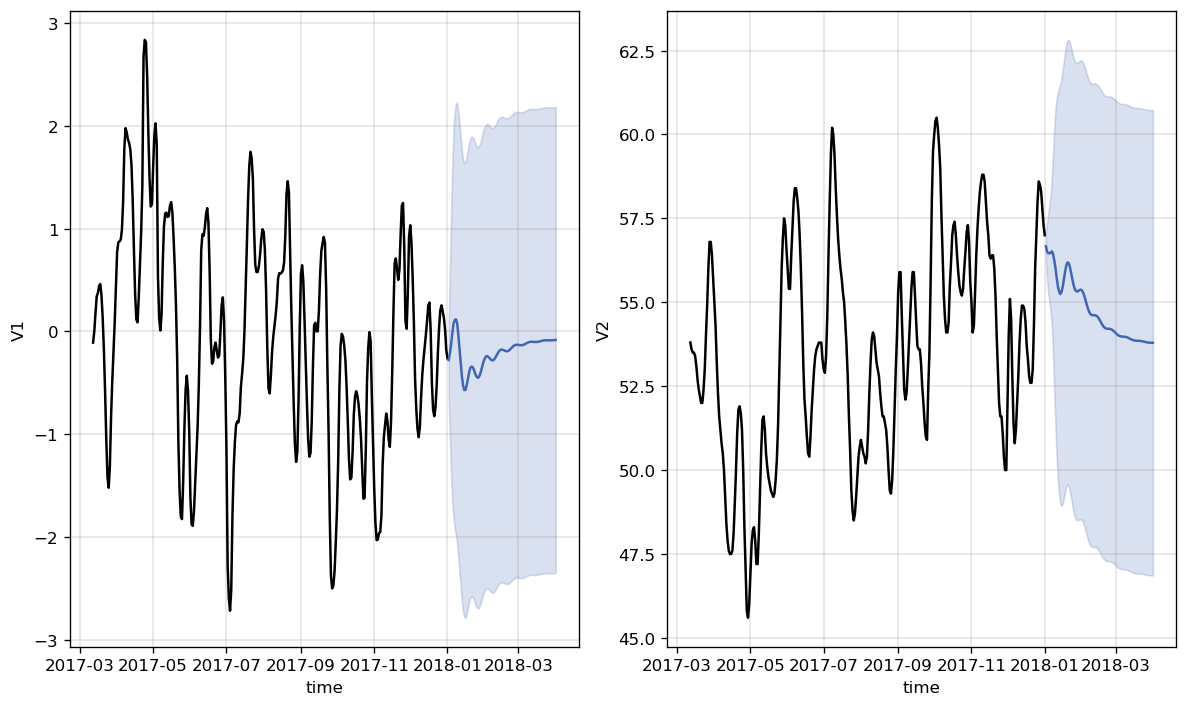

In [7]:
from kats.models.var import VARModel, VARParams

multi_df = pd.read_csv(retrieve_example_url(csv_name='multi_ts'),index_col=0)
multi_ts = TimeSeriesData(multi_df)
multi_params = VARParams()
multi_m = VARModel(multi_ts, multi_params)
multi_m.fit()
multi_fcst = multi_m.predict(steps=90)
multi_m.plot()

#### CUSUM Changepoint Detection

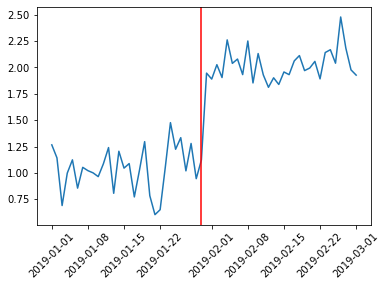

In [21]:
from kats.detectors.cusum_detection import CUSUMDetector
import matplotlib.pyplot as plt

np.random.seed(10)
data_dict = {
    'time': pd.date_range('2019-01-01', periods=60),
    'increase':np.concatenate([np.random.normal(1,0.2,30), np.random.normal(2,0.2,30)]),
    'decrease':np.concatenate([np.random.normal(1,0.3,50), np.random.normal(0.5,0.3,10)]),
}
df_increase_decrease = pd.DataFrame.from_dict(data_dict)
tsd = TimeSeriesData(df_increase_decrease.loc[:,['time','increase']])
detector = CUSUMDetector(tsd)
change_points = detector.detector(change_directions=['increase'])
plt.xticks(rotation=45)
detector.plot(change_points)

#### Another CUSUM Example

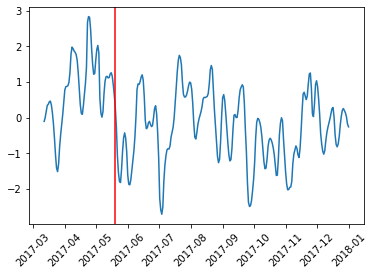

In [30]:
plt.clf()
multi_df_cusum = multi_df.copy()
multi_df_cusum = multi_df_cusum[['time','V1']]
multi_ts_cusum = TimeSeriesData(multi_df_cusum)
test_detector = CUSUMDetector(multi_ts_cusum)
test_change_points = test_detector.detector(change_directions=['decrease'])
plt.xticks(rotation=45)
test_detector.plot(test_change_points)